# Definición del proyecto de datos

Todo este proyecto tiene su base en la obtención de ciertos insights a partir de 3 bases de datos, las cuales tiene como cobertura geográfica el estado de los ángeles de estados unidos, es decir, es un proyecto donde en particular se estudiara las relaciones entre las diferentes bases de datos donde la región a estudiar son los ángeles.

- Crimen

- Negocios

- Vivienda

El contexto, es simple, trabajamos para el gobierno como alcalde de la ciudad y por tanto, las decisiones que se tomen, deberán de ser tomadas con una perspectiva meramente política, por ello es que los objetivos de este análisis deben de centrarse en la obtención de accionables claros a partir de las relaciones e interacciones encontradas en las bases de datos.

Los ángeles se dividen en 114 vecindarios, sobre los cuales se deberán de realizar el análisis, es decir, la investigación es a nivel de vecindarios. Por tanto, un punto relevante es evaluar la granularidad de la información en las bases de datos así como preguntas de la siguiente naturaleza

¿Qué vecindarios tienen una mayor tasa de muerte de negocios?, ¿se relaciona con la tasa de crimen?
¿Qué vecindarios tienen la mayor tasa de crimen?, ¿necesitan mayor atención policial?
¿Está esto afectando a los precios de las propiedades?  

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd                # Manejo de datos geoespaciales :contentReference[oaicite:8]{index=8}
from shapely.geometry import Point     # Construcción de geometrías puntuales :contentReference[oaicite:9]{index=9}

import requests
import io
from http.client import IncompleteRead

import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.oneway import test_scale_oneway
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.nonparametric import rank_compare_2indep

In [2]:
sns.set_style("darkgrid")
pd.options.display.float_format = "{:,.2f}".format

In [3]:
# URLs de descarga
crime_url    = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"      # Crimen 2020–Presente :contentReference[oaicite:10]{index=10}
business_url = "https://data.lacity.org/api/views/r4uk-afju/rows.csv?accessType=DOWNLOAD"     # Listado de negocios :contentReference[oaicite:11]{index=11}
zhvi_url     = "~/work/Neighborhood_zhvi.csv"
zhvi_url     = "./resources/Neighborhood_zhvi.csv"# ZHVI mensual por vecindario :contentReference[oaicite:12]{index=12}
areas_url    = "https://geohub.lacity.org/datasets/691805703915458da4b35d8088f29501_0.geojson" # Área por vecindario :contentReference[oaicite:13]{index=13}
bounds_url   = "https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0.geojson" # Límites de vecindario :contentReference[oaicite:14]{index=14}
census_url   = "https://data.lacity.org/api/views/nwj3-ufba/rows.csv?accessType=DOWNLOAD"      # Censo 2010 por consejo :contentReference[oaicite:15]{index=15}


In [4]:
def fetch_csv_stream(url: str, timeout: int = 60) -> io.StringIO:
    """
    Descarga un CSV por streaming.  
    En caso de IncompleteRead, reutiliza los bytes parciales descargados.
    """
    try:
        resp = requests.get(url, stream=True, timeout=timeout)
        resp.raise_for_status()
        # Leer todo el texto (posible IncompleteRead aquí)
        text = resp.text
    except IncompleteRead as e:
        # e.partial es un bytes con lo descargado antes de la excepción
        print('Incompleto:', e.partial)
        text = e.partial.decode('utf-8', errors='replace')
    return io.StringIO(text)

# Crimen

## Definición de requerimientos de datos

El primer paso para abordar el tratamiento de los datos que corresponden al crimen es comenzar por la definición de los requerimientos de datos. Este paso, se abordarán los temas relacionados con las fuentes, variables y objetivos de negocio para el análisis, estableciendo criterios de calidad y formatos esperados 

| Campo             | Descripción                                                                                                 |
|-------------------|-------------------------------------------------------------------------------------------------------------|
| **DR_NO**         | Número de expediente, formado por 2 dígitos de año + código de área + dígitos secuenciales                  |
| **Date Rptd**     | Fecha en la que se reportó el incidente al LAPD (MM/DD/YYYY)                                                |
| **DATE OCC**      | Fecha en que ocurrió el incidente (MM/DD/YYYY)                                                              |
| **TIME OCC**      | Hora de ocurrencia, en formato militar (24 h)                                                               |
| **AREA**          | Código de área (1–21) que identifica la estación comunitaria                                                |
| **AREA NAME**     | Nombre de la estación (“77th Street”, “Central”, etc.)                                                      |
| **Rpt Dist No**   | Número de distrito, subdivisión numérica dentro de cada área para análisis estadístico                       |
| **Part 1‑2**      | Indica si el delito es UCR Part I (crímenes más graves) o Part II                                            |
| **Crm Cd**        | Código de delito, código numérico principal asignado al incidente                                             |
| **Crm Cd Desc**   | Descripción textual del delito (`Crm Cd`)                                                                    |
| **MOCodes**       | Modus operandi: lista de códigos que describen comportamientos del sospechoso                                 |
| **Vict Age**      | Edad de la víctima, en años                                                                                  |
| **Vict Sex**      | Sexo de la víctima: M=Masculino, F=Femenino, X=Desconocido                                                   |
| **Vict Descent**  | Ascendencia/etnicidad de la víctima (H=Hispano, B=Negro, W=Blanco, A=Asiático, etc.)                         |
| **Premis Cd**     | Código de la ubicación (tipo de inmueble, vehículo o lugar)                                                  |
| **Premise Desc**  | Descripción de la ubicación (`Premis Cd`)                                                                    |
| **Weapon Used Cd**| Código del arma o instrumento utilizado                                                                       |
| **Weapon Desc**   | Descripción del arma (`Weapon Used Cd`)                                                                      |
| **Status**        | Estado del caso (p. ej. IC=In Commission, CA=Cleared by Arrest, etc.)                                         |
| **Status Desc**   | Descripción del código de estado (`Status`)                                                                  |
| **Crm Cd 1**      | Delito principal (más grave) del incidente                                                                   |
| **Crm Cd 2**      | Delito secundario 1 (si aplica)                                                                              |
| **Crm Cd 3**      | Delito secundario 2 (si aplica)                                                                              |
| **Crm Cd 4**      | Delito secundario 3 (si aplica)                                                                              |
| **LOCATION**      | Ubicación aproximada (número de manzana redondeado al centenar más cercano)                                  |
| **Cross Street**  | Calle transversal más cercana al punto de `LOCATION`                                                         |
| **LAT**           | Latitud en coordenadas geográficas (WGS 84) del punto del incidente                                           |
| **LON**           | Longitud en coordenadas geográficas (WGS 84) del punto del incidente                                          |


In [5]:
crime_buffer = fetch_csv_stream(crime_url)

raw_df = pd.read_csv(crime_buffer, low_memory=False) 

del crime_buffer

In [6]:
raw_df.columns = raw_df.columns.str.strip()

# Mostrar las primeras columnas para verificar nombres exactos
print(raw_df.columns.tolist())

['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005109 entries, 0 to 1005108
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1005109 non-null  int64  
 1   Date Rptd       1005109 non-null  object 
 2   DATE OCC        1005109 non-null  object 
 3   TIME OCC        1005109 non-null  int64  
 4   AREA            1005109 non-null  int64  
 5   AREA NAME       1005109 non-null  object 
 6   Rpt Dist No     1005109 non-null  int64  
 7   Part 1-2        1005109 non-null  int64  
 8   Crm Cd          1005109 non-null  int64  
 9   Crm Cd Desc     1005109 non-null  object 
 10  Mocodes         853403 non-null   object 
 11  Vict Age        1005109 non-null  int64  
 12  Vict Sex        860379 non-null   object 
 13  Vict Descent    860367 non-null   object 
 14  Premis Cd       1005093 non-null  float64
 15  Premis Desc     1004521 non-null  object 
 16  Weapon Used Cd  327259 non-null   fl

In [8]:
raw_df.head(3)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.00,998.00,NaN,NaN,1900 S LONGWOOD AV,NaN,34.04,-118.35
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.00,998.00,NaN,NaN,1000 S FLOWER ST,NaN,34.04,-118.26
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.00,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.02,-118.30


In [9]:
raw_df["Date Rptd"] = pd.to_datetime(raw_df["Date Rptd"], format="%m/%d/%Y %I:%M:%S %p", errors="raise")
raw_df["DATE OCC"] = pd.to_datetime(raw_df["DATE OCC"], format="%m/%d/%Y %I:%M:%S %p", errors="raise")

# Negocios

In [10]:
business_bufer = fetch_csv_stream(business_url)

business_df = pd.read_csv(business_bufer, low_memory=False)

del business_bufer

In [11]:
business_df.columns = business_df.columns.str.strip()

business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607924 entries, 0 to 1607923
Data columns (total 16 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   LOCATION ACCOUNT #         1607924 non-null  object 
 1   BUSINESS NAME              1607924 non-null  object 
 2   DBA NAME                   246256 non-null   object 
 3   STREET ADDRESS             1607822 non-null  object 
 4   CITY                       1607814 non-null  object 
 5   ZIP CODE                   1607924 non-null  object 
 6   LOCATION DESCRIPTION       1607801 non-null  object 
 7   MAILING ADDRESS            369932 non-null   object 
 8   MAILING CITY               369944 non-null   object 
 9   MAILING ZIP CODE           369813 non-null   object 
 10  NAICS                      628889 non-null   float64
 11  PRIMARY NAICS DESCRIPTION  628889 non-null   object 
 12  COUNCIL DISTRICT           1607924 non-null  int64  
 13  LOCATION STA

In [12]:
business_df["LOCATION START DATE"] = pd.to_datetime(business_df["LOCATION START DATE"], format="%m/%d/%Y", errors='coerce')
business_df["LOCATION END DATE"] = pd.to_datetime(business_df["LOCATION END DATE"], format="%m/%d/%Y", errors='coerce')

In [13]:
business_df.head(3)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,"444,130.00",Hardware stores,0,2020-10-01,NaT,"(33.9581, -118.2926)"
1,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,NaN,NaN,8,2020-09-03,NaT,"(33.9597, -118.3028)"
2,0003109317-0001-3,GINA BRADFORD,NaN,7847 CANBY AVENUE,RESEDA,91335-2096,7847 CANBY 91335,7847 CANBY AVENUE,RESEDA,91335-2096,NaN,NaN,4,2018-01-01,NaT,"(34.2133, -118.535)"


# Inmuebles

## Definición de requerimientos de datos

Indice de valor de vivienda de Zollow (ZHVI): Esta es una medida del valor típico de la vivienda y de los cambios del mercado en una región y tip de vivienda determiados. Refleja el valor medio de las vivienda que se encuentra entre el percentil 36 - 65. Es disponible como medida suavizada y ajustada estacionalizada, así como en su versión cruda.


| Campo        | Descripción                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------| 
| **RegionID**   | Identificador numérico único de la región (vecindario).                                                        |
| **SizeRank**   | Ranking de tamaño de la región según número de viviendas o población (1 = más grande).                          |
| **RegionName** | Nombre del vecindario (e.g., “Hollywood Hills West”).                                                           |
| **RegionType** | Tipo de región: aquí siempre “neighborhood” (vecindario).                                                       |
| **StateName**  | Nombre completo del estado (e.g., “California”).                                                               |
| **State**      | Código del estado (abreviatura de dos letras, p.ej. “CA”).                                                      |
| **City**       | Nombre de la ciudad principal (aquí siempre “Los Angeles”).                                                     |
| **Metro**      | Nombre del área metropolitana (p.ej. “Los Angeles-Long Beach-Anaheim”).                                         |
| **CountyName** | Nombre del condado (p.ej. “Los Angeles County”).                                                                |
| **date**       | Fecha del dato de ZHVI, al final del mes (formato YYYY-MM-DD).                                                  |
| **price**      | Valor típico de vivienda (ZHVI) en dólares para ese mes y vecindario, suavizado y ajustado estacionalmente.     |



In [29]:
zhhv_df= pd.read_csv('Home_Values.csv') # una ves leemos lois datos  de home values 
zhty_df= pd.read_csv('data_type.csv')# tipo de dtaos
zhvi_df= pd.read_csv('Neighborhood.csv')# becondarios 


In [30]:

zhty_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2025-04-30,2025-06-30,2026-03-31
0,102001,0,United States,country,NaN,2025-03-31,-0.30,-0.90,-1.70
1,394913,1,"New York, NY",msa,NY,2025-03-31,0.00,-0.60,-2.40
2,753899,2,"Los Angeles, CA",msa,CA,2025-03-31,-0.40,-1.00,-1.90
3,394463,3,"Chicago, IL",msa,IL,2025-03-31,0.00,-0.60,-1.90
4,394514,4,"Dallas, TX",msa,TX,2025-03-31,-0.60,-1.70,-2.90


In [31]:
zhvi_df.head(3)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31
0,112345,0,Maryvale,neighborhood,AZ,AZ,Phoenix,"Phoenix-Mesa-Chandler, AZ",Maricopa County,"68,834.53",...,"348,732.83","349,152.99","349,079.86","348,319.12","347,149.63","345,953.30","345,149.62","344,048.87","342,202.34","339,531.74"
1,192689,1,Paradise,neighborhood,NV,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,"133,420.55",...,"388,246.16","390,457.02","392,167.80","393,421.29","394,326.70","395,471.17","396,970.32","398,267.79","398,724.19","398,131.18"
2,270958,2,Upper West Side,neighborhood,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,"386,532.73",...,"1,184,489.80","1,188,552.63","1,197,697.13","1,202,479.49","1,206,482.55","1,219,156.80","1,237,621.99","1,253,386.26","1,261,486.74","1,265,104.67"


In [32]:

zhhv_df.head(2)


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31
0,102001,0,United States,country,NaN,"121,667.51","121,881.57","122,147.02","122,716.37","123,371.63",...,"357,820.28","357,967.68","358,209.99","358,658.63","359,244.61","359,735.50","360,452.37","361,079.29","361,536.63","361,262.75"
1,394913,1,"New York, NY",msa,NY,"217,199.04","218,122.01","219,053.54","220,941.16","222,895.86",...,"662,513.26","665,269.54","669,025.46","673,066.20","676,602.74","679,383.03","681,173.48","682,248.94","683,535.54","685,225.16"


In [33]:
zhvi_df_angeles = zhvi_df[(zhvi_df["State"] == "CA") & (zhvi_df["City"] == "Los Angeles")]
zhvi_df_angeles.head(4) # guardamos en una variable(zhng_df_angeles) lo que filtramos 

zhvi_df_angeles['RegionName'].unique()

array(['South Los Angeles', 'Southeast Los Angeles', 'Hollywood',
       'North Hollywood', 'Van Nuys', 'Mid City', 'Sylmar', 'San Pedro',
       'Northridge', 'Woodland Hills', 'Boyle Heights', 'Sherman Oaks',
       'Pacoima', 'Koreatown', 'Westlake', 'Reseda', 'Panorama City',
       'Valley Glen', 'North Hills', 'Central City', 'Sun Valley',
       'Westwood', 'Wilmington', 'Canoga Park', 'Granada Hills',
       'Winnetka', 'Highland Park', 'Lake Balboa', 'Downtown',
       'Mid City West', 'Encino', 'El Sereno', 'Harbor Gateway',
       'West Hills', 'Palms', 'Chatsworth', 'Mar Vista', 'Studio City',
       'Watts', 'Arleta', 'Mid Wilshire', 'Westchester', 'Silver Lake',
       'Tarzana', 'Park Mesa Heights', 'Brentwood', 'Sawtelle', 'Del Rey',
       'Hollywood Hills', 'Lincoln Heights', 'Eagle Rock',
       'Jefferson Park', 'Venice', 'Harvard Heights', 'Tujunga',
       'MacArthur Park', 'Los Feliz', 'Valley Village', 'University Park',
       'Harbor City', 'Rampart Village', 

In [34]:
cat_df_angeles = zhvi_df_angeles.columns[:9]

data = {cat : len(zhvi_df_angeles[cat].unique()) for cat in cat_df_angeles}

data  #Se asume que esas columnas son  variables categóricas o de interés. las 9


{'RegionID': 99,
 'SizeRank': 99,
 'RegionName': 99,
 'RegionType': 1,
 'StateName': 1,
 'State': 1,
 'City': 1,
 'Metro': 1,
 'CountyName': 1}

In [35]:
zhvi_df_angeles = zhvi_df_angeles.drop(["RegionType", "StateName", "State", "City", "Metro", "CountyName"], axis=1)
zhvi_df_angeles.head(4) # se eliminan la variables que no son de nuestro intere, por lo tanto se deja el resto 

,RegionID,SizeRank,RegionName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31
4,118208,4,South Los Angeles,"131,468.00","131,493.26","131,751.27","132,401.45","133,341.40","134,253.93","135,138.93",...,"670,999.25","673,646.31","678,946.96","685,630.61","691,096.82","694,881.77","697,629.09","696,065.29","691,088.58","682,069.76"
8,268496,8,Southeast Los Angeles,"115,164.13","115,386.20","115,727.94","116,404.05","117,196.34","117,950.66","118,684.52",...,"596,429.79","599,207.61","603,319.34","608,728.92","613,247.05","617,258.82","620,176.66","618,569.98","612,878.16","603,408.39"
21,32059,21,Hollywood,"230,073.46","231,296.47","233,210.75","236,519.41","239,880.03","242,462.72","245,718.20",...,"977,985.55","976,743.55","978,381.64","982,692.89","983,672.88","982,186.10","978,676.07","971,112.99","962,090.07","950,297.09"
41,46795,41,North Hollywood,"164,554.22","165,268.11","166,125.35","167,912.91","169,731.17","171,618.41","173,491.77",...,"851,452.54","855,050.71","861,192.39","869,556.65","876,056.38","880,851.50","884,796.20","882,428.93","876,983.13","868,226.44"


In [36]:
#Obteniendo los nombres de las columnas las cuales
columns = zhvi_df_angeles.columns[:3]

#Convirtiendo el dataframe en un formato largo para el análisis de datos
zhvi_df_angeles_long = zhvi_df_angeles.melt(id_vars=columns, var_name="date", value_name="Price")

#Convirtiendo la columna de fecha a un formato de fecha
zhvi_df_angeles_long["date"] = pd.to_datetime(zhvi_df_angeles_long["date"], errors="coerce")

#Presentando el dataframe
zhvi_df_angeles_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29997 entries, 0 to 29996
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionID    29997 non-null  int64         
 1   SizeRank    29997 non-null  int64         
 2   RegionName  29997 non-null  object        
 3   date        29997 non-null  datetime64[ns]
 4   Price       29660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.1+ MB


In [37]:
zhvi_df_angeles_long.isnull().sum()/len(zhvi_df_angeles_long)

RegionID     0.00
SizeRank     0.00
RegionName   0.00
date         0.00
Price        0.01
dtype: float64

In [38]:
zhvi_df_angeles_long["year"] = zhvi_df_angeles_long["date"].dt.year
zhvi_df_angeles_long["month"] = zhvi_df_angeles_long["date"].dt.month

### ## Perfilado de los datos

In [39]:
zhvi_df_angeles_long.describe()

,RegionID,SizeRank,date,Price,year,month
count,"29,997.00","29,997.00",29997,"29,660.00","29,997.00","29,997.00"
mean,"196,956.57","1,315.70",2012-08-30 04:35:38.613861376,"670,304.00","2,012.13",6.46
min,"7,877.00",4.00,2000-01-31 00:00:00,"102,782.19","2,000.00",1.00
25%,"41,466.00",172.00,2006-04-30 00:00:00,"357,933.79","2,006.00",3.00
50%,"118,849.00",389.00,2012-08-31 00:00:00,"551,034.62","2,012.00",6.00
75%,"274,049.00","1,283.00",2018-12-31 00:00:00,"829,798.73","2,018.00",9.00
max,"787,940.00","16,104.00",2025-03-31 00:00:00,"4,249,986.85","2,025.00",12.00
std,"173,062.18","2,633.73",NaN,"474,124.93",7.29,3.46


In [40]:
zhvi_df_angeles_long["Price"].kurtosis() # mediante la hurtosis se mide distribución con colas pesadas tipo distr.normal 

9.380194401833513

In [41]:
zhvi_df_angeles_long["Price"].skew() # se calcula simestria muchos valores muy altos o muy bajos y de que lados estan cargados 

2.4065381297372253

Se toma el 49 y 50 para realizar justamenet esta simetria 

In [42]:
len(zhvi_df_angeles_long["RegionName"].unique())/2j #Obtiene nombre unicos de de vecindarios  y los contamos para

-49.5j

In [43]:
zhvi_groupby_angeles_min = zhvi_df_angeles_long.groupby("RegionName").agg({"Price" : ["mean", "std", "min", "max"]}).sort_values(("Price", "mean"), ascending=False)

index_min = zhvi_groupby_angeles_min.index[:3]

zhvi_groupby_angeles_min.head(3)

Price                                   
                          mean        std        min          max
RegionName                                                       
Bel Air           2,287,136.11 953,235.18 967,291.34 4,249,986.85
Pacific Palisades 2,037,686.99 855,392.75 867,298.34 3,841,522.87
Beverly Crest     1,616,843.27 717,436.99 643,850.12 3,085,203.31

In [44]:
zhvi_groupby_angeles_mean = zhvi_df_angeles_long.groupby("RegionName").agg({"Price" : ["mean", "std", "min", "max"]}).sort_values(("Price", "mean"), ascending=True)

index_mean = zhvi_groupby_angeles_mean.index[48:51]

zhvi_groupby_angeles_mean.iloc[48:51,:]

Price                                   
                      mean        std        min          max
RegionName                                                   
University Park 557,384.36 249,659.61 218,743.13 1,021,346.00
Koreatown       557,955.31 194,054.32 197,149.85   867,035.16
Granada Hills   559,854.98 206,100.52 248,005.26 1,029,196.36

In [45]:
zhvi_groupby_angeles_max = zhvi_df_angeles_long.groupby("RegionName").agg({"Price" : ["mean", "std", "min", "max"]}).sort_values(("Price", "mean"), ascending=True)

index_max = zhvi_groupby_angeles_max.index[:3]

zhvi_groupby_angeles_max.head(3)

Price                                 
                            mean        std        min        max
RegionName                                                       
Watts                 275,245.29 150,477.43 102,848.65 601,812.90
Southeast Los Angeles 300,023.32 152,996.16 115,164.13 620,176.66
Central City          306,644.74 150,611.28 119,938.63 613,575.41

In [46]:
zhvi_df_angeles_long_muestra = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"].isin([*index_min, *index_mean, *index_max])]
zhvi_df_angeles_long_muestra  # Para comparar cómo se comportan en el tiempo los vecindarios con menores, promedio y mayores precios.

,RegionID,SizeRank,RegionName,date,Price,year,month
1,268496,8,Southeast Los Angeles,2000-01-31,"115,164.13",2000,1
13,268236,84,Koreatown,2000-01-31,"197,149.85",2000,1
19,273197,137,Central City,2000-01-31,"119,938.63",2000,1
24,31817,172,Granada Hills,2000-01-31,"248,005.26",2000,1
38,118849,285,Watts,2000-01-31,"102,848.65",2000,1
...,...,...,...,...,...,...,...
29936,118849,285,Watts,2025-03-31,"588,973.98",2025,3
29956,268540,494,University Park,2025-03-31,"988,209.26",2025,3
29964,19810,614,Pacific Palisades,2025-03-31,"3,644,430.87",2025,3
29977,113749,1670,Beverly Crest,2025-03-31,"2,826,861.03",2025,3


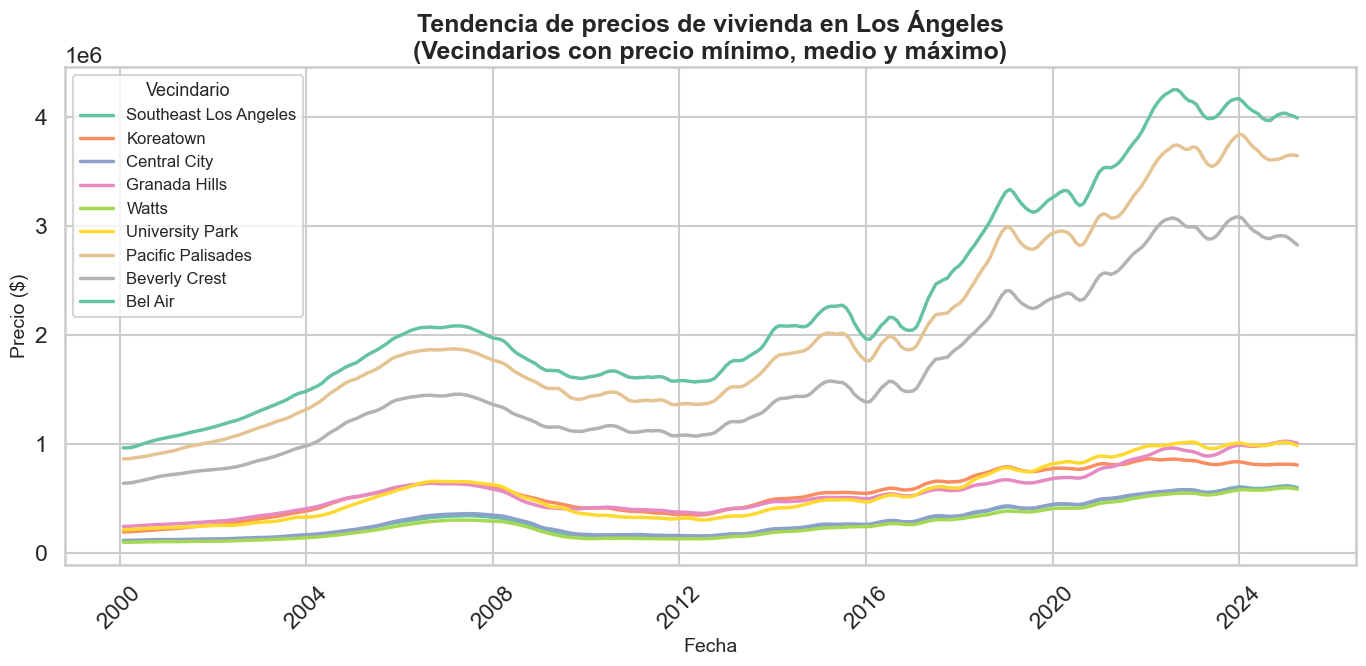

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo estético
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 7))

# Gráfico de líneas
sns.lineplot(
    data=zhvi_df_angeles_long_muestra,
    x="date",
    y="Price",
    hue="RegionName",
    palette="Set2",
    linewidth=2.5
)

# Título y etiquetas
plt.title("Tendencia de precios de vivienda en Los Ángeles\n(Vecindarios con precio mínimo, medio y máximo)", fontsize=18, fontweight="bold")
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Precio ($)", fontsize=14)

# Mejoras visuales
plt.xticks(rotation=45)
plt.legend(title="Vecindario", fontsize=12, title_fontsize=13)
plt.tight_layout()

# Mostrar gráfico
plt.show()

## Tratamiento de datos nulos | Imputación por regresión

Para el tratamiento de los datos nulos, se opta por la imputación por regresión, dado que se tiene una gran cantidad de datos y por tanto, es posible realizar un análisis de regresión para estimar los valores mas versimiles. En este sentido, el primer paso es identificar la naturaleza de los datos faltantes, 

In [48]:
zhvi_df_angeles_long.isnull().sum()/len(zhvi_df_angeles_long)

RegionID     0.00
SizeRank     0.00
RegionName   0.00
date         0.00
Price        0.01
year         0.00
month        0.00
dtype: float64

In [49]:
city_with_null_values = zhvi_df_angeles_long[zhvi_df_angeles_long["Price"].isnull()]["RegionName"].unique()
city_with_null_values

array(['Chinatown', 'Playa Vista'], dtype=object)

In [119]:
zhvi_df_city_null_values = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"].isin([*city_with_null_values])]
zhvi_df_angeles_long['RegionName'].unique()



array(['South Los Angeles', 'Southeast Los Angeles', 'Hollywood',
       'North Hollywood', 'Van Nuys', 'Mid City', 'Sylmar', 'San Pedro',
       'Northridge', 'Woodland Hills', 'Boyle Heights', 'Sherman Oaks',
       'Pacoima', 'Koreatown', 'Westlake', 'Reseda', 'Panorama City',
       'Valley Glen', 'North Hills', 'Central City', 'Sun Valley',
       'Westwood', 'Wilmington', 'Canoga Park', 'Granada Hills',
       'Winnetka', 'Highland Park', 'Lake Balboa', 'Downtown',
       'Mid City West', 'Encino', 'El Sereno', 'Harbor Gateway',
       'West Hills', 'Palms', 'Chatsworth', 'Mar Vista', 'Studio City',
       'Watts', 'Arleta', 'Mid Wilshire', 'Westchester', 'Silver Lake',
       'Tarzana', 'Park Mesa Heights', 'Brentwood', 'Sawtelle', 'Del Rey',
       'Hollywood Hills', 'Lincoln Heights', 'Eagle Rock',
       'Jefferson Park', 'Venice', 'Harvard Heights', 'Tujunga',
       'MacArthur Park', 'Los Feliz', 'Valley Village', 'University Park',
       'Harbor City', 'Rampart Village', 

In [51]:
zhvi_df_city_null_values["Year"] = zhvi_df_city_null_values["date"].dt.year
zhvi_df_city_null_values["Month"] = zhvi_df_city_null_values["date"].dt.month

C:\Users\52331\AppData\Local\Temp\ipykernel_33916\2936462951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zhvi_df_city_null_values["Year"] = zhvi_df_city_null_values["date"].dt.year
C:\Users\52331\AppData\Local\Temp\ipykernel_33916\2936462951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zhvi_df_city_null_values["Month"] = zhvi_df_city_null_values["date"].dt.month


In [52]:
zhvi_df_city_null_values.isnull().sum()/len(zhvi_df_city_null_values)

RegionID     0.00
SizeRank     0.00
RegionName   0.00
date         0.00
Price        0.56
year         0.00
month        0.00
Year         0.00
Month        0.00
dtype: float64

In [53]:
zhvi_df_city_null_values.pivot_table(index="Year", columns="RegionName", values="Price", aggfunc=["count", "mean"])

count                   mean             
RegionName Chinatown Playa Vista  Chinatown  Playa Vista
Year                                                    
2000               0           0        NaN          NaN
2001               0           0        NaN          NaN
2002               0           0        NaN          NaN
2003               0           0        NaN          NaN
2004               0           0        NaN          NaN
2005               0           0        NaN          NaN
2006               0           0        NaN          NaN
2007               0           0        NaN          NaN
2008               0          12        NaN   717,930.56
2009               0          12        NaN   648,563.82
2010               0          12        NaN   629,108.19
2011               0          12        NaN   588,470.29
2012               0          12        NaN   574,318.26
2013               0          12        NaN   666,609.46
2014               0          12        NaN   766,116.35
2015               0          12        NaN   839,635.66
2016               0          12        NaN   915,769.96
2017               0          12        NaN   979,618.31
2018               0          12        NaN 1,113,044.39
2019               0          12        NaN 1,158,868.76
2020              11          12 712,589.99 1,142,573.86
2021              12          12 783,444.18 1,181,657.49
2022              12          12 852,482.80 1,303,183.59
2023              12          12 866,129.35 1,306,765.02
2024              12          12 871,318.02 1,366,481.11
2025               3           3 843,582.50 1,379,152.08

### Estimación de por regresion

A través del análisis realizado por los datos de ZHVI, se ha podido observar que existen ciertos vecindarios que tienen un valor de vivienda nulo. Esto puede ser debido a que no existen datos disponibles para esos vecindarios en el periodo analizado. Por tanto, se ha decidido imputar los valores nulos a través de una regresión lineal múltiple, donde la variable dependiente es el precio de la vivienda y las variables independientes son las características de los vecindarios (tamaño, población, etc.), considerando la cercancia de los vecindarios para realizar la regresión, es decir, para ajustar el modelo no se tomaran todos los vecindarios, sino que se tomaran solo aquellos que se encuentren en un rango menor a 10 kilometros de distancia.

Esto tiene el objetivo de poder aproximar con una mayor verosimilitud el valor real de la vienda en ese punto  concreto, ya que se espera que los vecindarios cercanos tengan un valor de vivienda similar. Por tanto, se espera que la regresión lineal múltiple sea capaz de predecir el valor de la vivienda en esos vecindarios nulos a partir de los datos de los vecindarios cercanos.

Es por ello, que para los dos vecindarios que tiene valores se ha decidido considerar los siguientes vecindarios para la regresión lineal múltiple, para cada uno de ellos

**Regiones cercanas a Chinatown**

| Barrio             | Ubicación relativa a Chinatown‑LA           | Distancia aprox. (km / mi) |
|--------------------|---------------------------------------------|----------------------------|
| Elysian Park       | Norte                                       | 2.0 km / 1.2 mi            |
| Lincoln Heights    | Noreste (cruzando el río L.A.)              | 2.7 km / 1.6 mi            |
| Echo Park          | Noroeste                                    | 2.7 km / 1.7 mi            |
| Cypress Park       | NNE (valle del río L.A.)                    | 3.4 km / 2.1 mi            |
| Westlake           | Suroeste (MacArthur Park)                   | 4.2 km / 2.6 mi            |
| Boyle Heights      | Sureste (al este del río L.A.)              | 4.4 km / 2.7 mi            |
| Mount Washington   | NNE (colinas de NELA)                       | 4.5 km / 2.8 mi            |

**Regiones cercanas a Playa Vista**

| Barrio         | Ubicación relativa a Playa Vista       | Distancia aprox. (km / mi) |
|----------------|----------------------------------------|----------------------------|
| Del Rey        | Noreste inmediato                      | 1.5 km / 0.9 mi            |
| Westchester    | Sur                                    | 2.5 km / 1.6 mi            |
| Playa del Rey  | Suroeste (costero)                     | 3.1 km / 1.9 mi            |
| Mar Vista      | Norte                                  | 3.5 km / 2.2 mi            |
| Venice         | Noroeste (costero)                     | 4.3 km / 2.7 mi            |
| Palms          | Noreste                                | 5.0 km / 3.1 mi            |
| Sawtelle       | Norte‑noroeste                         | 7.3 km / 4.5 mi            |


### Proceso de estimación

In [54]:
barrios_cercamos_chinatown = ["Lincoln Heights", "Elysia Park", "Echo Park", "Boyle Heights", "Cypress Park", "Mount Washington", "Westlake"]

barrios_cercamos_playa_vista = ["Del Rey", "Westchester", "Playa del Rey", "Mar Vista", "Venice", "Palms", "Sawtelle"]

In [55]:
df_barrios_cercamos_chinatown = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"].isin(barrios_cercamos_chinatown)]
df_chinatown = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"] == "Chinatown"]

df_barrios_cercamos_chinatown.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1818 entries, 10 to 29979
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionID    1818 non-null   int64         
 1   SizeRank    1818 non-null   int64         
 2   RegionName  1818 non-null   object        
 3   date        1818 non-null   datetime64[ns]
 4   Price       1818 non-null   float64       
 5   year        1818 non-null   int32         
 6   month       1818 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2), object(1)
memory usage: 99.4+ KB


In [56]:
df_chinatown.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 83 to 29981
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionID    303 non-null    int64         
 1   SizeRank    303 non-null    int64         
 2   RegionName  303 non-null    object        
 3   date        303 non-null    datetime64[ns]
 4   Price       62 non-null     float64       
 5   year        303 non-null    int32         
 6   month       303 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2), object(1)
memory usage: 16.6+ KB


In [57]:
df_chinatown.describe()

,RegionID,SizeRank,date,Price,year,month
count,303.00,303.00,303,62.00,303.00,303.00
mean,"276,257.00","2,208.00",2012-08-30 04:35:38.613861376,"820,156.93","2,012.13",6.46
min,"276,257.00","2,208.00",2000-01-31 00:00:00,"691,847.98","2,000.00",1.00
25%,"276,257.00","2,208.00",2006-05-15 12:00:00,"775,253.11","2,006.00",3.00
50%,"276,257.00","2,208.00",2012-08-31 00:00:00,"847,133.81","2,012.00",6.00
75%,"276,257.00","2,208.00",2018-12-15 12:00:00,"868,833.50","2,018.00",9.00
max,"276,257.00","2,208.00",2025-03-31 00:00:00,"888,150.90","2,025.00",12.00
std,0.00,0.00,NaN,"61,447.60",7.30,3.47


In [58]:
df_barrios_cercamos_chinatown.describe()

,RegionID,SizeRank,date,Price,year,month
count,"1,818.00","1,818.00",1818,"1,818.00","1,818.00","1,818.00"
mean,"193,187.67",632.67,2012-08-30 04:35:38.613861376,"480,410.62","2,012.13",6.46
min,"113,886.00",72.00,2000-01-31 00:00:00,"129,138.98","2,000.00",1.00
25%,"116,206.00",93.00,2006-04-30 00:00:00,"270,658.90","2,006.00",3.00
50%,"192,438.50",489.00,2012-08-31 00:00:00,"423,823.75","2,012.00",6.00
75%,"268,134.00",850.00,2018-12-31 00:00:00,"639,496.21","2,018.00",9.00
max,"276,023.00","1,803.00",2025-03-31 00:00:00,"1,247,953.92","2,025.00",12.00
std,"77,636.79",589.48,NaN,"259,528.80",7.29,3.47


In [59]:
df_chinatown["Price"].skew()

-0.9191505357653911

In [60]:
df_barrios_cercamos_chinatown["Price"].skew()

0.9130086426636489

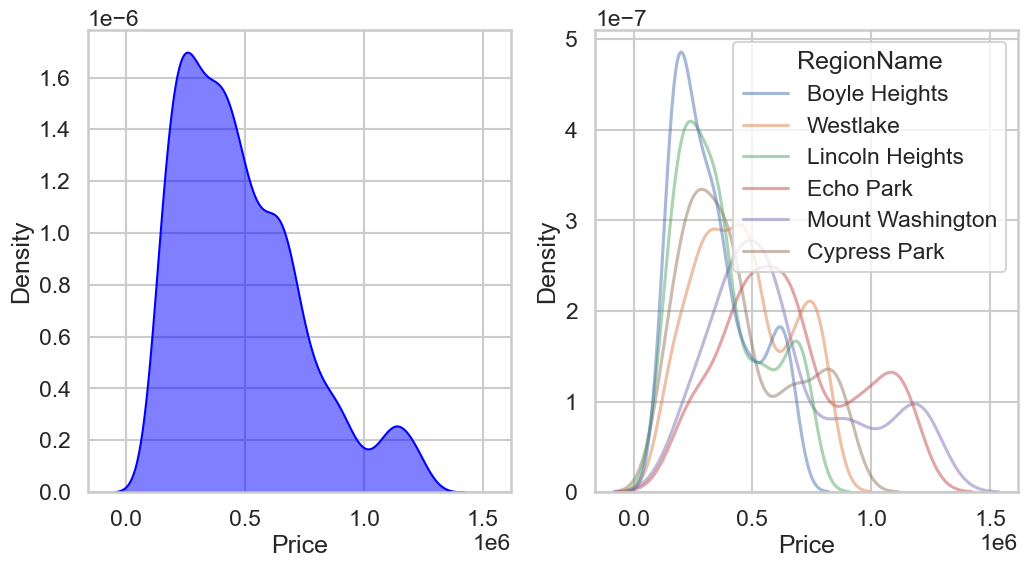

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

sns.kdeplot(data=df_barrios_cercamos_chinatown, x="Price", fill=True, color="blue", alpha=0.5, ax=ax1)
sns.kdeplot(data=df_barrios_cercamos_chinatown, x="Price", fill=False, alpha=0.5, ax=ax2, hue="RegionName")

plt.show()

COMO ES QUE FECTA



Está creando dos gráficos de densidad (KDE) lado a lado para comparar cómo se distribuyen los precios de vivienda cerca de Chinatown

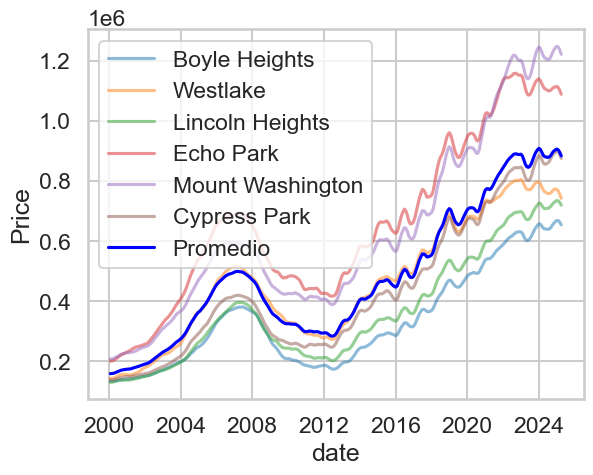

In [62]:
df_groupby_chinatown_mean = df_barrios_cercamos_chinatown.groupby("date").agg({"Price" : "mean"}).reset_index()
df_groupby_chinatown_mean

sns.lineplot(data=df_barrios_cercamos_chinatown, x="date", y="Price", hue="RegionName", palette="tab10", alpha=0.5)
sns.lineplot(data=df_groupby_chinatown_mean, x="date", y="Price", color="blue", label="Promedio")

plt.legend()
plt.show()



In [63]:
fecha_primer_reporte = df_chinatown[df_chinatown["Price"] > 0]["date"].min()

df_barrios_cercanos_chinatown_primer_fecha = df_barrios_cercamos_chinatown[df_barrios_cercamos_chinatown["date"] >= fecha_primer_reporte].copy()

df_barrios_cercanos_chinatown_primer_fecha.describe()

,RegionID,SizeRank,date,Price,year,month
count,372.00,372.00,372,372.00,372.00,372.00
mean,"193,187.67",632.67,2022-09-14 22:50:19.354838784,"837,027.68","2,022.18",6.37
min,"113,886.00",72.00,2020-02-29 00:00:00,"490,042.92","2,020.00",1.00
25%,"116,206.00",93.00,2021-05-31 00:00:00,"671,532.60","2,021.00",3.00
50%,"192,438.50",489.00,2022-09-15 00:00:00,"777,402.28","2,022.00",6.00
75%,"268,134.00",850.00,2023-12-31 00:00:00,"1,030,152.96","2,023.00",9.00
max,"276,023.00","1,803.00",2025-03-31 00:00:00,"1,247,953.92","2,025.00",12.00
std,"77,719.97",590.11,NaN,"213,235.85",1.51,3.47


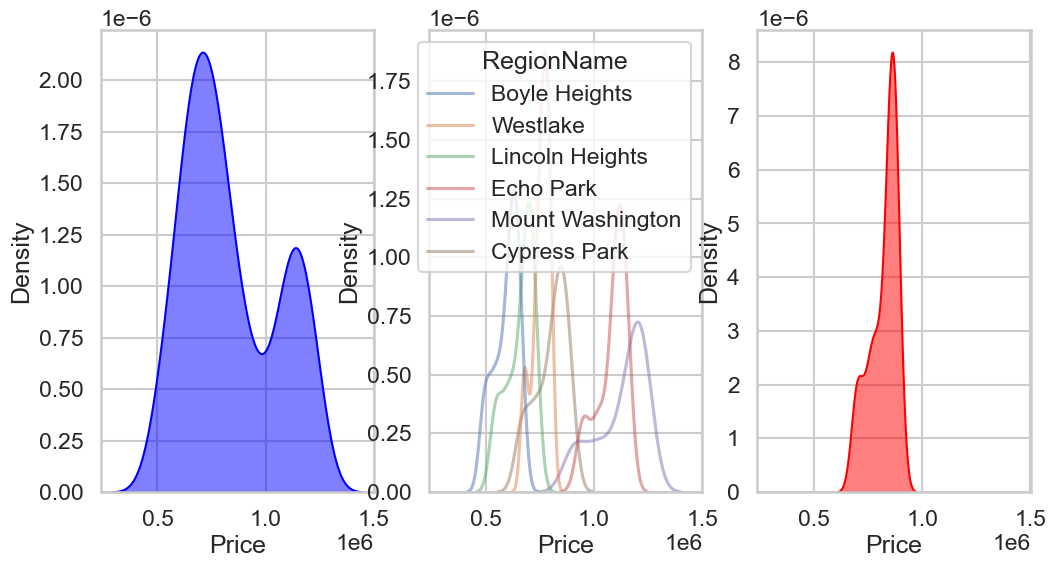

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharex=True)

sns.kdeplot(data=df_barrios_cercanos_chinatown_primer_fecha, x="Price", fill=True, color="blue", alpha=0.5, ax=ax1)
sns.kdeplot(data=df_barrios_cercanos_chinatown_primer_fecha, x="Price", fill=False, alpha=0.5, ax=ax2, hue="RegionName")

sns.kdeplot(data=df_chinatown, x="Price", fill=True, color="red", alpha=0.5, ax=ax3)

plt.show()

### Análisis de distribución de precios cerca de Chinatown

En este paso, se generaron dos gráficos de densidad (KDE) para analizar cómo se distribuyen los precios de vivienda en los vecindarios cercanos a Chinatown:

- El primer gráfico muestra la distribución general de precios en todos los vecindarios combinados.
- El segundo gráfico compara las distribuciones por vecindario individual utilizando diferentes colores.

Esto permite visualizar tanto la tendencia global como las diferencias específicas entre vecindarios en términos de precios.

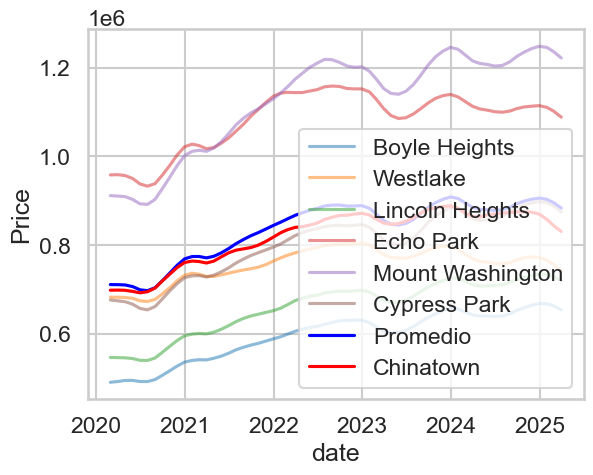

In [65]:
df_groupby_chinatown_mean_primer_fecha = df_groupby_chinatown_mean[df_groupby_chinatown_mean["date"] >= fecha_primer_reporte]

sns.lineplot(data=df_barrios_cercanos_chinatown_primer_fecha, x="date", y="Price", hue="RegionName", palette="tab10", alpha=0.5)

#Proyeccion de la serie con el promedio de los datos
sns.lineplot(data=df_groupby_chinatown_mean_primer_fecha, x="date", y="Price", color="blue", label="Promedio")

#Proyeccion de la serie con datos faltantes
sns.lineplot(data=df_chinatown, x="date", y="Price", color="red", label="Chinatown")

plt.legend()
plt.show()

### Evaluaremos supuestos de normalidad

In [66]:
df_barrios_cercanos_chinatown_primer_fecha["Price"].mean()

837027.6755986665

In [67]:
df_barrios_cercanos_chinatown_primer_fecha["Price"].mean() - df_chinatown["Price"].mean()

16870.74746822694

In [68]:
df_barrios_cercanos_chinatown_primer_fecha["Price"].to_csv("x")

In [69]:
from scipy.stats import jarque_bera

data_barrios_cercanos = df_barrios_cercanos_chinatown_primer_fecha["Price"].dropna()

JBn, p_n = jarque_bera(data_barrios_cercanos)

print(f"Jarque-Bera: {JBn:.2f}, p-value: {p_n:.8f}")

Jarque-Bera: 29.79, p-value: 0.00000034


Qué significa el resultado?

    Si el p-valor es alto (mayor que 0.05, por ejemplo), no rechazamos la hipótesis nula, lo que sugiere que los datos siguen una distribución normal.

    Si el p-valor es bajo (menos de 0.05), se rechaza la hipótesis nula, lo que indica que los datos probablemente no siguen una distribución normal.

In [70]:
from scipy.stats import skew, kurtosis

data_chinatown = df_chinatown[df_chinatown["Price"] > 0]["Price"]

JBn, p_n = jarque_bera(data_chinatown)
skew_n = skew(data_chinatown)
kurt_n = kurtosis(data_chinatown)

print(f"Jarque-Bera: {JBn:.2f}, p-value: {p_n:.8f}, skew: {skew_n:.2f}, kurtosis: {kurt_n:.2f}")

Jarque-Bera: 9.09, p-value: 0.01060183, skew: -0.90, kurtosis: -0.55


In [71]:
# Ejecutar Levene clásico análisis de varianza
result = test_scale_oneway(
    (data_chinatown, data_barrios_cercanos),
    method='equal',
    center='mean',
    transform='abs'
)

print(f"Levene F = {result.statistic:.3f}, p-value = {result.pvalue:.3f}")
# Ejemplo de salida: Levene F = 4.762, p-value = 0.011

Levene F = 85.337, p-value = 0.000


Este análisis nos permite verificar si los datos de los precios cumplen con una distribución normal, a través de la prueba de Jarque-Bera. Además, calculas el sesgo (skew) y la curtosis para obtener más información sobre la forma de la distribución de los precios, como su asimetría y la forma de sus picos y colas. Si el p-value de la prueba de Jarque-Bera es bajo, podrías concluir que los precios no siguen una distribución normal.

In [72]:
#Análisis de la media
res = rank_compare_2indep(data_chinatown, data_barrios_cercanos, use_t=True)

# Alternativamente, para ver un resumen:
print(res.summary())

                  Probability sample 1 is stochastically larger                   
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
prob(x1>x2) c0     0.5556      0.027      2.088      0.037       0.503       0.608


In [73]:
# Ejecutar Levene (center='mean') o Brown–Forsythe (center='median')
res = test_scale_oneway(
    (data_chinatown, data_barrios_cercanos),
    method='bf',    # 'levene' o 'bf' (Brown–Forsythe)
    center='mean',      # para Levene típico; usar 'median' para BF
    transform='abs'     # valor absoluto de la desviación
)

print(f"Levene F = {res.statistic:.3f}, p-value = {res.pvalue:.3f}")

Levene F = 349.049, p-value = 0.000


In [74]:
# Fix data type issue by ensuring all columns have the correct data types beforehand
# Convert 'Price' column to numeric and handle non-numeric scenarios properly before
df_barrios_cercamos_chinatown['Price'] = pd.to_numeric(df_barrios_cercamos_chinatown['Price'], errors='coerce')

# Ensure 'date' column is in datetime format to avoid dtype issues
df_barrios_cercamos_chinatown['date'] = pd.to_datetime(df_barrios_cercamos_chinatown['date'], errors='coerce')

# Drop rows with missing Date or Price values to avoid issues with regression model
df_barrios_cercamos_chinatown = df_barrios_cercamos_chinatown.dropna(subset=['date', 'Price'])

# Recalculate 't' after fixing potential issues with the 'date' column
df_barrios_cercamos_chinatown['t'] = (df_barrios_cercamos_chinatown['date'] - df_barrios_cercamos_chinatown['date'].min()).dt.days

# Generate dummy variables for 'RegionName' ensuring all objects are properly handled
region_dummies = pd.get_dummies(df_barrios_cercamos_chinatown['RegionName'], prefix='Region', drop_first=True)

# Prepare the matrix of regressors, ensuring all columns are numeric
exog = pd.concat([
    df_barrios_cercamos_chinatown[['t']].astype(float),  # Ensure column is float
    region_dummies.astype(float)  # Ensure dummy variables are float
], axis=1)

exog = sm.add_constant(exog)

# Ensure the target variable 'y' contains only numeric values
y = df_barrios_cercamos_chinatown['Price'].astype(float)  # Explicitly set to float

# Align indices of 'y' and 'exog' to prevent mismatches
exog = exog.loc[y.index]

# Fit the OLS model
model = sm.OLS(y, exog)
result = model.fit()

# Output model summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1268.
Date:                Sat, 10 May 2025   Prob (F-statistic):               0.00
Time:                        11:23:16   Log-Likelihood:                -23745.
No. Observations:                1818   AIC:                         4.750e+04
Df Residuals:                    1811   BIC:                         4.754e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -9

C:\Users\52331\AppData\Local\Temp\ipykernel_33916\4281368082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barrios_cercamos_chinatown['Price'] = pd.to_numeric(df_barrios_cercamos_chinatown['Price'], errors='coerce')
C:\Users\52331\AppData\Local\Temp\ipykernel_33916\4281368082.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barrios_cercamos_chinatown['date'] = pd.to_datetime(df_barrios_cercamos_chinatown['date'], errors='coerce')


In [76]:
model.predict()

TypeError: RegressionModel.predict() missing 1 required positional argument: 'params'

**CALCULO DE KPI**

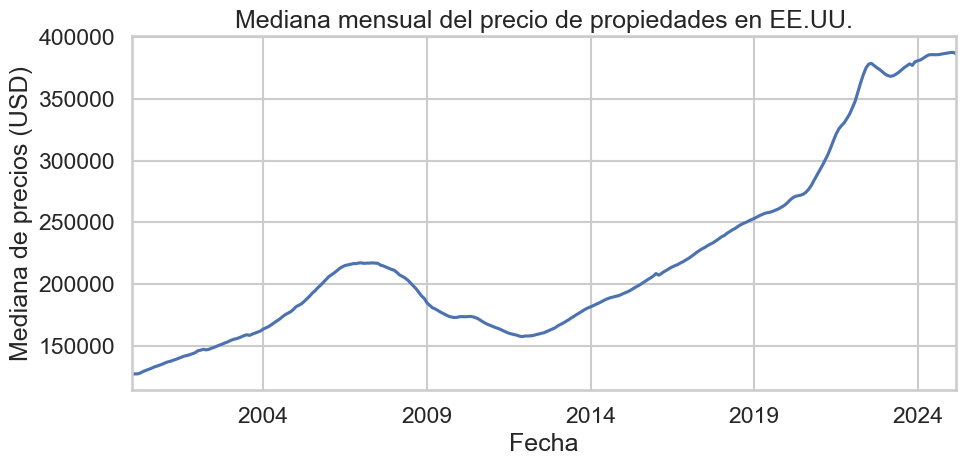

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Transforma el DataFrame zhvi_df para tener fechas como índice y regiones como columnas
zhvi_transposed = zhvi_df.set_index(['RegionID', 'RegionName']).drop(  # elimino colum no numericas que no son necesarias parfa el calculo de la mediana 
    columns=['SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']
).T

# Convierte el índice (fechas) al tipo datetime
zhvi_transposed.index = pd.to_datetime(zhvi_transposed.index)

# Calcula la mediana mensual de todas las regiones calculando la mediana por me, considerando todos los vecindarios 
mediana_mensual = zhvi_transposed.median(axis=1)

# Gráfico de la mediana del precio de propiedades
plt.figure(figsize=(10, 5))
mediana_mensual.plot(title="Mediana mensual del precio de propiedades en EE.UU.")
plt.xlabel("Fecha")
plt.ylabel("Mediana de precios (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


**DONDE** 



Operación matemática aplicada:

Para cada mes (columna con formato fecha), se calcula la mediana de los valores de todas las filas (es decir, de todos los vecindarios).
Mediana 


**Cambio YOY=(Medianat -Medianat-12/Medianat-12)*100**



**Donde**


*t es el mes (por ejemplo, 2024-06-30).


*xit es el precio de la propiedad para el vecindario i en el mest t


*n es el número total de vecindarios

In [84]:
print(zhvi_df.head())
print(zhvi_df.columns)
print(zhvi_df.index)

   RegionID  SizeRank         RegionName    RegionType StateName State  \
0    112345         0           Maryvale  neighborhood        AZ    AZ   
1    192689         1           Paradise  neighborhood        NV    NV   
2    270958         2    Upper West Side  neighborhood        NY    NY   
3    270957         3    Upper East Side  neighborhood        NY    NY   
4    118208         4  South Los Angeles  neighborhood        CA    CA   

          City                                  Metro          CountyName  \
0      Phoenix              Phoenix-Mesa-Chandler, AZ     Maricopa County   
1    Las Vegas       Las Vegas-Henderson-Paradise, NV        Clark County   
2     New York  New York-Newark-Jersey City, NY-NJ-PA     New York County   
3     New York  New York-Newark-Jersey City, NY-NJ-PA     New York County   
4  Los Angeles     Los Angeles-Long Beach-Anaheim, CA  Los Angeles County   

   2000-01-31  ...   2024-06-30   2024-07-31   2024-08-31   2024-09-30  \
0   68,834.53  ...

In [ ]:
neighborhood.index = pd.to_datetime(zhvi_df.index)

In [82]:
print(zhvi_df.index[:10])

RangeIndex(start=0, stop=10, step=1)


In [85]:
import pandas as pd
import matplotlib.pyplot as plt

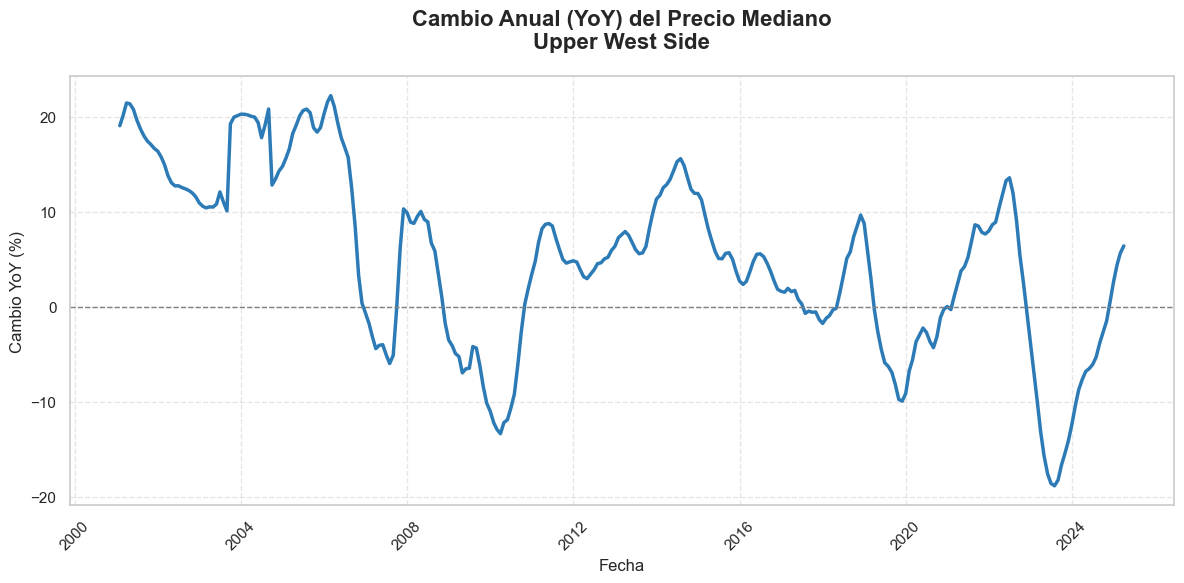

In [126]:

import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set(style="whitegrid")

# Crear la figura
plt.figure(figsize=(12, 6))

# Trazar la línea con estilo
plt.plot(yoy_change.index, yoy_change.values, color="#2C7BB6", linewidth=2.5)

# Título estilizado
plt.title("Cambio Anual (YoY) del Precio Mediano\nUpper West Side", fontsize=16, fontweight='bold', pad=20)

# Etiquetas de ejes
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Cambio YoY (%)", fontsize=12)

# Línea horizontal en 0 para referencia
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Mejorar ticks y leyenda
plt.xticks(rotation=45)
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.tight_layout()

# Mostrar gráfico
plt.show()

In [123]:
import numpy as np
import pandas as pd

# Asegúrate de que la columna 'date' esté en formato datetime
zhvi_df_angeles_long['date'] = pd.to_datetime(zhvi_df_angeles_long['date'])

# Crear columna 'year'
zhvi_df_angeles_long['year'] = zhvi_df_angeles_long['date'].dt.year

# Filtrar entre 2020 y 2025
df_filtrado = zhvi_df_angeles_long[
    (zhvi_df_angeles_long['year'] >= 2020) & 
    (zhvi_df_angeles_long['year'] <= 2025)
].copy()

# Asegurar que 'Price' sea numérico
df_filtrado['Price'] = (
    df_filtrado['Price']
    .astype(str)
    .str.replace(',', '', regex=False)
    .replace('', np.nan)
    .astype(float)
)

# Eliminar precios nulos
df_filtrado = df_filtrado.dropna(subset=['Price'])

# Agrupar por vecindario y calcular promedio
promedios = df_filtrado.groupby('RegionName')['Price'].mean().sort_values(ascending=False)

# Mostrar resultados
print(promedios.tail(20))

RegionName
North Hills             772,205.47
Lakeview Terrace        766,074.28
Winnetka                761,488.22
Sun Valley              755,904.14
Westlake                755,004.32
Van Nuys                737,384.33
Mission Hills           736,854.92
Park Mesa Heights       723,898.47
El Sereno               719,613.36
Harbor Gateway          719,409.24
Reseda                  716,699.72
Sylmar                  714,662.47
University Hills        709,197.59
Harbor City             702,893.81
Arleta                  702,239.62
Crenshaw                696,400.89
Canoga Park             683,055.62
Lincoln Heights         658,029.99
Downtown                651,195.78
South Los Angeles       631,107.11
Wilmington              627,269.48
Pico-Union              626,994.34
Pacoima                 624,919.89
Panorama City           613,464.80
Boyle Heights           593,768.18
Rampart Village         581,983.30
Central City            549,146.71
Southeast Los Angeles   548,937.76
Watts    

In [92]:
vecindarios_con_datos = df_filtrado.groupby('RegionName')['Price'].count()
print(vecindarios_con_datos[vecindarios_con_datos > 0].count())

16782


In [114]:
promedios

RegionName
Gables Estates               21,854,672.19
Old Cutler Bay               11,460,425.41
Beverly Hills Gateway        10,701,065.02
Paradise Cove                 8,739,934.88
Trousdale Estates             8,715,594.81
                                  ...     
Bullard Hill                     25,179.42
Civic Park                       24,762.01
Washington Addition              24,384.86
Odette,Witherbee,Iroquios        24,071.95
Northend Recreation Center       23,261.36
Name: Price, Length: 16782, dtype: float64

In [96]:
promedios['RegionName'].unique()

KeyError: 'RegionName'

In [111]:
df_filtrado['RegionName'].unique()

array(['Maryvale', 'Paradise', 'Upper West Side', ..., 'South Grandview',
       'Rustic Meadows', 'Summerset Estates'], dtype=object)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52d42f7b-e3e4-4fa6-bf85-d2691d7edf9a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>